# Import Libraries

In [11]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# The model
Let's start with the model we first saw

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,432
              ReLU-4           [-1, 64, 24, 24]               0
            Conv2d-5          [-1, 128, 22, 22]          73,728
              ReLU-6          [-1, 128, 22, 22]               0
         MaxPool2d-7          [-1, 128, 11, 11]               0
            Conv2d-8           [-1, 32, 11, 11]           4,096
              ReLU-9           [-1, 32, 11, 11]               0
           Conv2d-10             [-1, 64, 9, 9]          18,432
             ReLU-11             [-1, 64, 9, 9]               0
           Conv2d-12            [-1, 128, 7, 7]          73,728
             ReLU-13            [-1, 128, 7, 7]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [8]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.2355167418718338 Batch_id=468 Accuracy=26.28: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3413, Accuracy: 8957/10000 (89.57%)

EPOCH: 1


Loss=0.09255716949701309 Batch_id=468 Accuracy=94.52: 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0951, Accuracy: 9691/10000 (96.91%)

EPOCH: 2


Loss=0.03935491666197777 Batch_id=468 Accuracy=97.23: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0742, Accuracy: 9751/10000 (97.51%)

EPOCH: 3


Loss=0.09343507885932922 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:15<00:00, 29.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0689, Accuracy: 9801/10000 (98.01%)

EPOCH: 4


Loss=0.0303239393979311 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:16<00:00, 29.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0455, Accuracy: 9860/10000 (98.60%)

EPOCH: 5


Loss=0.01981302909553051 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:15<00:00, 29.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0476, Accuracy: 9848/10000 (98.48%)

EPOCH: 6


Loss=0.0588221400976181 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9863/10000 (98.63%)

EPOCH: 7


Loss=0.020967625081539154 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:16<00:00, 29.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0410, Accuracy: 9866/10000 (98.66%)

EPOCH: 8


Loss=0.03715543448925018 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:15<00:00, 29.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9850/10000 (98.50%)

EPOCH: 9


Loss=0.03171214088797569 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:16<00:00, 28.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9875/10000 (98.75%)

EPOCH: 10


Loss=0.03575142100453377 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:15<00:00, 29.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9884/10000 (98.84%)

EPOCH: 11


Loss=0.018975725397467613 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:16<00:00, 29.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9903/10000 (99.03%)

EPOCH: 12


Loss=0.019309984520077705 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:16<00:00, 29.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9885/10000 (98.85%)

EPOCH: 13


Loss=0.016223125159740448 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:16<00:00, 29.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9880/10000 (98.80%)

EPOCH: 14


Loss=0.010553908534348011 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:15<00:00, 29.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9881/10000 (98.81%)

EPOCH: 15


Loss=0.0039321258664131165 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:16<00:00, 29.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0410, Accuracy: 9883/10000 (98.83%)

EPOCH: 16


Loss=0.004890722688287497 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:16<00:00, 29.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9885/10000 (98.85%)

EPOCH: 17


Loss=0.02356487326323986 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:16<00:00, 29.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9885/10000 (98.85%)

EPOCH: 18


Loss=0.004565955139696598 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:16<00:00, 29.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9889/10000 (98.89%)

EPOCH: 19


Loss=0.004128095228224993 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:16<00:00, 28.87it/s]



Test set: Average loss: 0.0359, Accuracy: 9898/10000 (98.98%)



Text(0.5, 1.0, 'Test Accuracy')

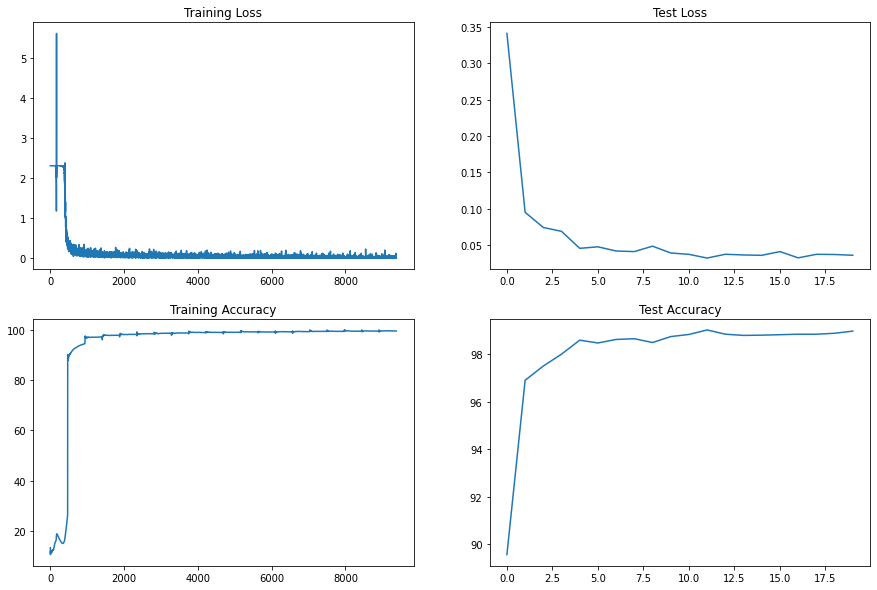

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")